In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from math import sqrt
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import plotly.graph_objects as go

from IPython.display import Image

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from scipy import stats


In [2]:
data = pd.read_parquet("../../../data/covid_combined_dataset.parquet.gzip")

In [3]:
data.columns

Index(['countyFIPS', 'County Name', 'State', 'StateFIPS', 'Date', 'Cases',
       'Death', 'population'],
      dtype='object')

### Utilize Linear and Non-Linear (polynomial) regression models to compare trends for a single state and its counties (top 5 with highest number of cases). Start your data from the first day of infections.

In [4]:
IL_data = data[data['State']=='IL']
IL_data.head()

,countyFIPS,County Name,State,StateFIPS,Date,Cases,Death,population
451010,17001,Adams County,IL,17,2020-01-22,0,0,65435
451011,17001,Adams County,IL,17,2020-01-23,0,0,65435
451012,17001,Adams County,IL,17,2020-01-24,0,0,65435
451013,17001,Adams County,IL,17,2020-01-25,0,0,65435
451014,17001,Adams County,IL,17,2020-01-26,0,0,65435


In [5]:
#resetting the index
IL_data.reset_index(inplace=True,drop=True)
IL_data.head()
IL_data[:760]

,countyFIPS,County Name,State,StateFIPS,Date,Cases,Death,population
0,17001,Adams County,IL,17,2020-01-22,0,0,65435
1,17001,Adams County,IL,17,2020-01-23,0,0,65435
2,17001,Adams County,IL,17,2020-01-24,0,0,65435
3,17001,Adams County,IL,17,2020-01-25,0,0,65435
4,17001,Adams County,IL,17,2020-01-26,0,0,65435
...,...,...,...,...,...,...,...,...
755,17001,Adams County,IL,17,2022-02-15,21877,232,65435
756,17001,Adams County,IL,17,2022-02-16,21927,232,65435
757,17001,Adams County,IL,17,2022-02-17,21964,234,65435
758,17003,Alexander County,IL,17,2020-01-22,0,0,5761


In [6]:
#new cases and deaths per day
IL_data['New cases']=IL_data['Cases'].diff()
IL_data["New deaths"]=IL_data['Death'].diff()

In [7]:
#Removing the first row 
IL_data=IL_data[IL_data['Date'] != '2020-01-22']

In [8]:
# changing the negative values to zer
IL_data['New cases'][IL_data['New cases'] < 0] = 0
IL_data['New deaths'][IL_data['New deaths'] < 0] = 0

In [9]:
IL_data_day = IL_data.groupby("Date").sum()

IL_data_day.reset_index(inplace=True)

IL_data_day[295:300]

,Date,countyFIPS,StateFIPS,Cases,Death,population,New cases,New deaths
295,2020-11-13,1744404,1734,551731,10891,12671821,15385.0,45.0
296,2020-11-14,1744404,1734,562744,11088,12671821,11013.0,197.0
297,2020-11-15,1744404,1734,573369,11162,12671821,10625.0,74.0
298,2020-11-16,1744404,1734,585012,11203,12671821,11643.0,42.0
299,2020-11-17,1744404,1734,597537,11316,12671821,12525.0,114.0


In [10]:
IL_data_day1=IL_data_day[['Date','New cases','New deaths']]
IL_data_day1.head()

,Date,New cases,New deaths
0,2020-01-23,0.0,0.0
1,2020-01-24,1.0,0.0
2,2020-01-25,0.0,0.0
3,2020-01-26,0.0,0.0
4,2020-01-27,0.0,0.0


In [11]:
#getting the index of the firstoccurance of  case and death from covid
IL_day1_case_index= IL_data_day1['New cases'].ne(0).idxmax() 
IL_day1_death_index= IL_data_day1['New deaths'].ne(0).idxmax()

In [12]:
#printing the index values
print('day1 case index is ',IL_day1_case_index)
print('day1 death index is',IL_day1_death_index)

day1 case index is  1
day1 death index is 54


In [13]:
#removinf the rows before the first day of case and deat occurance in data
IL_day1_cases=IL_data_day1[['Date','New cases']][IL_day1_case_index:]
IL_day1_deaths=IL_data_day1[['Date','New deaths']][IL_day1_death_index:]

In [14]:
#gtting the count of days from isrt day os case occurance
IL_day1_cases['day_count']=''
c=IL_day1_case_index
for i in range(1,IL_day1_cases.shape[0]+1):
    IL_day1_cases['day_count'][c]=i
    c=c+1

#displayig the data with day count    
IL_day1_cases.tail()


,Date,New cases,day_count
752,2022-02-13,3063.0,752
753,2022-02-14,2729.0,753
754,2022-02-15,2882.0,754
755,2022-02-16,3323.0,755
756,2022-02-17,2543.0,756


In [15]:
#gtting the count of days from fisrt day os death occurance
IL_day1_deaths['day_count']=''
d=IL_day1_death_index
for i in range(1,IL_day1_deaths.shape[0]+1):
    IL_day1_deaths['day_count'][d]=i
    d=d+1

#displayig the data with day count    
IL_day1_deaths.tail()

,Date,New deaths,day_count
752,2022-02-13,50.0,699
753,2022-02-14,9.0,700
754,2022-02-15,53.0,701
755,2022-02-16,105.0,702
756,2022-02-17,73.0,703


## Linear Regression Model for cases

In [16]:
#getting teh only cases, deaths and day count in the table for model
IL_day1_cases_m =IL_day1_cases[['day_count','New cases']]

In [17]:
IL_day1_cases_m.tail()

,day_count,New cases
752,752,3063.0
753,753,2729.0
754,754,2882.0
755,755,3323.0
756,756,2543.0


In [18]:
#splitting the data into tain test
#considef=ring 10 percent 70 cases for test data
x_train=IL_day1_cases_m['day_count'][:680]
y_train=IL_day1_cases_m['New cases'][:680]

#test data
x_test=IL_day1_cases_m['day_count'][680:]
y_test=IL_day1_cases_m['New cases'][680:]

In [19]:
#getting the data for x and y independently
x_train = np.array(x_train).reshape(-1,1)
x_test = np.array(x_test).reshape(-1,1)


In [20]:
#fitting the linear regression
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [21]:
lr_pred_test = lr.predict(x_test)
lr_pred_test

array([3596.50716885, 3599.06331411, 3601.61945938, 3604.17560464,
       3606.73174991, 3609.28789518, 3611.84404044, 3614.40018571,
       3616.95633097, 3619.51247624, 3622.0686215 , 3624.62476677,
       3627.18091204, 3629.7370573 , 3632.29320257, 3634.84934783,
       3637.4054931 , 3639.96163836, 3642.51778363, 3645.07392889,
       3647.63007416, 3650.18621943, 3652.74236469, 3655.29850996,
       3657.85465522, 3660.41080049, 3662.96694575, 3665.52309102,
       3668.07923629, 3670.63538155, 3673.19152682, 3675.74767208,
       3678.30381735, 3680.85996261, 3683.41610788, 3685.97225315,
       3688.52839841, 3691.08454368, 3693.64068894, 3696.19683421,
       3698.75297947, 3701.30912474, 3703.86527001, 3706.42141527,
       3708.97756054, 3711.5337058 , 3714.08985107, 3716.64599633,
       3719.2021416 , 3721.75828687, 3724.31443213, 3726.8705774 ,
       3729.42672266, 3731.98286793, 3734.53901319, 3737.09515846,
       3739.65130373, 3742.20744899, 3744.76359426, 3747.31973

In [22]:
#getiing the rmse value for linear regression model
rmse = sqrt(mean_squared_error(y_test, lr_pred_test))
rmse

16094.725929956741

#### Trend Line

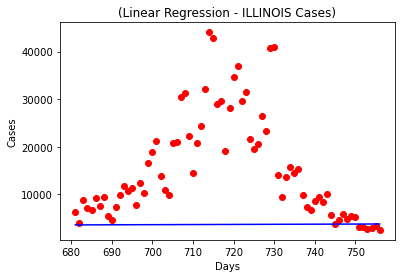

In [23]:
#plotting for linear regression for ILLINOIS state cases
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test, lr_pred_test, color='blue')
plt.title('(Linear Regression - ILLINOIS Cases)')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.show()


## Polynomial Regression for Cases

In [24]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

### Trend Line

RMSE for degree 1 is 16094.725929956741
RMSE for degree 2 is 18192.552578151302
RMSE for degree 3 is 15700.947640312419
RMSE for degree 4 is 12691.911900861121


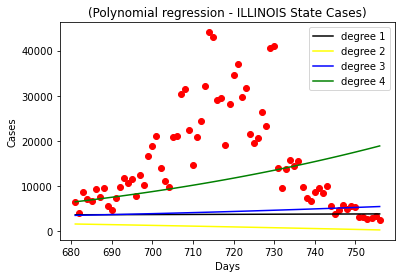

In [25]:
#performing polynomial regression for the ILLINOIS state
degree=1
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict1 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict1))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=2
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict2 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict2))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=3
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict3 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict3))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=4
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict4 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict4))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))


#PLotting th graph for all 4 degrees for polynomial regression

plt.scatter(x_test, y_test, color='red')
plt.plot(x_test,poly_test_predict1 , color='black',label='degree 1')
plt.plot(x_test,poly_test_predict2 , color='yellow',label='degree 2')
plt.plot(x_test,poly_test_predict3 , color='blue',label='degree 3')
plt.plot(x_test,poly_test_predict4 , color='green',label='degree 4')
plt.title('(Polynomial regression - ILLINOIS State Cases)')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.legend()
plt.show()


In [26]:
#plotting the predited values
poly_test_predict4

array([ 6473.40715375,  6580.0523288 ,  6688.05826332,  6797.4336496 ,
        6908.18720322,  7020.32766309,  7133.86379137,  7248.80437355,
        7365.1582184 ,  7482.93415799,  7602.14104768,  7722.78776614,
        7844.88321532,  7968.43632047,  8093.45603014,  8219.95131617,
        8347.93117371,  8477.40462118,  8608.38070032,  8740.86847615,
        8874.87703699,  9010.41549446,  9147.49298347,  9286.11866224,
        9426.30171226,  9568.05133833,  9711.37676855,  9856.28725431,
       10002.7920703 , 10150.90051449, 10300.62190817, 10451.96559591,
       10604.94094558, 10759.55734834, 10915.82421866, 11073.75099428,
       11233.34713626, 11394.62212896, 11557.58548   , 11722.24672033,
       11888.61540419, 12056.7011091 , 12226.51343589, 12398.06200868,
       12571.35647488, 12746.40650522, 12923.22179369, 13101.81205761,
       13282.18703756, 13464.35649745, 13648.33022447, 13834.1180291 ,
       14021.72974512, 14211.17522962, 14402.46436296, 14595.60704881,
      

### Confdence Interval for best fit from above rsme

As rmse for the ploynomial degree 4 is least when compared to linear and polynomial other 3 degrees we considered plotting confidence interval for degree 4 polynomial

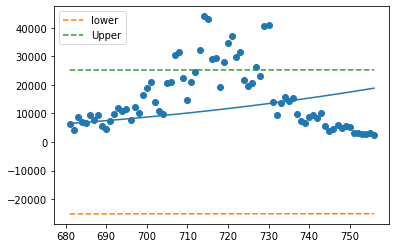

In [27]:
# ref: https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

upper, lower = [], []
for i in range(len(x_test)):
    lower.append(get_prediction_interval(i,y_test, poly_test_predict4)[0])
    upper.append(get_prediction_interval(i,y_test, poly_test_predict4)[2])

plt.scatter(x_test,y_test)
plt.plot(x_test,poly_test_predict4)
plt.plot(x_test,lower,'--',label='lower')
plt.plot(x_test,upper,'--',label='Upper')
plt.legend(loc='upper left')

### Illinois state cases Forecast

In [28]:
IL_day1_cases_m.tail()

,day_count,New cases
752,752,3063.0
753,753,2729.0
754,754,2882.0
755,755,3323.0
756,756,2543.0


In [29]:
future_dates= np.arange(756,766)

In [30]:
future_dates

array([756, 757, 758, 759, 760, 761, 762, 763, 764, 765])

In [31]:
future_predicted_cases=polynomial_rg.predict(future_dates.reshape(-1,1))

Text(0.5, 1.0, 'future predications for given dates')

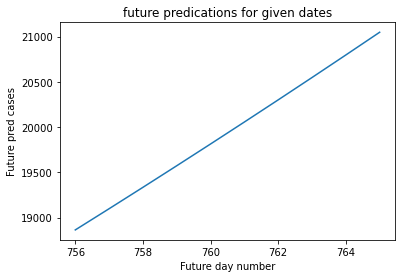

In [32]:
plt.plot(future_dates,future_predicted_cases)
plt.xlabel('Future day number')
plt.ylabel('Future pred cases')
plt.title("future predications for given dates")

## Linear regression for Deaths

In [33]:
#getting teh only deaths, deaths and day count in the table for model
IL_day1_deaths_m =IL_day1_deaths[['day_count','New deaths']]

In [34]:
IL_day1_deaths_m.tail()

,day_count,New deaths
752,699,50.0
753,700,9.0
754,701,53.0
755,702,105.0
756,703,73.0


In [35]:
#splitting the data into tain test
x_train=IL_day1_deaths_m['day_count'][:640]
y_train=IL_day1_deaths_m['New deaths'][:640]

#test data
x_test=IL_day1_deaths_m['day_count'][640:]
y_test=IL_day1_deaths_m['New deaths'][640:]


In [36]:
#getting the data for x and y independently
x_train = np.array(x_train).reshape(-1,1)
x_test = np.array(x_test).reshape(-1,1)


In [37]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(640, 1)
(63, 1)
(640,)
(63,)


In [38]:
#fitting the Linear regression model
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [39]:
lr_pred_test = lr.predict(x_test)
lr_pred_test

array([24.17762617, 24.10314139, 24.0286566 , 23.95417182, 23.87968703,
       23.80520225, 23.73071746, 23.65623267, 23.58174789, 23.5072631 ,
       23.43277832, 23.35829353, 23.28380874, 23.20932396, 23.13483917,
       23.06035439, 22.9858696 , 22.91138482, 22.83690003, 22.76241524,
       22.68793046, 22.61344567, 22.53896089, 22.4644761 , 22.38999132,
       22.31550653, 22.24102174, 22.16653696, 22.09205217, 22.01756739,
       21.9430826 , 21.86859782, 21.79411303, 21.71962824, 21.64514346,
       21.57065867, 21.49617389, 21.4216891 , 21.34720432, 21.27271953,
       21.19823474, 21.12374996, 21.04926517, 20.97478039, 20.9002956 ,
       20.82581082, 20.75132603, 20.67684124, 20.60235646, 20.52787167,
       20.45338689, 20.3789021 , 20.30441732, 20.22993253, 20.15544774,
       20.08096296, 20.00647817, 19.93199339, 19.8575086 , 19.78302382,
       19.70853903, 19.63405424, 19.55956946])

In [40]:
rmse = sqrt(mean_squared_error(y_test, lr_pred_test))
rmse

73.60445192305579

#### Trend Line

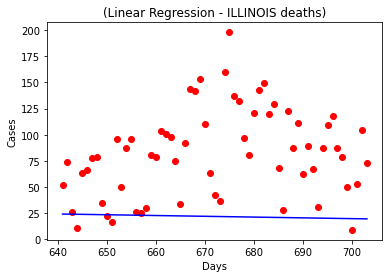

In [41]:
#plotting for linear regression for ILLINOIS  state deaths
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test, lr_pred_test, color='blue')
plt.title('(Linear Regression - ILLINOIS deaths)')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.show()

## Polynomial Regression for Deaths

### Trend Line

RMSE for degree 1 is 73.6044519230558
RMSE for degree 2 is 89.27842159272681
RMSE for degree 3 is 70.50746305123863
RMSE for degree 4 is 62.780836819401955


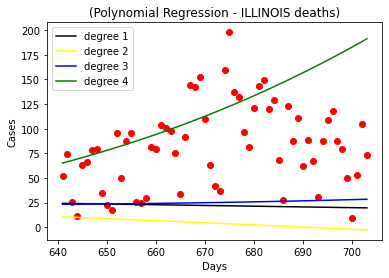

In [42]:
#polynomial regression for ILLINOIS state deaths

degree=1
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict1 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict1))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=2
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict2 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict2))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=3
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict3 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict3))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=4
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict4 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict4))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

#ploting for all 4 degrees for polynomial regression 
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test,poly_test_predict1 , color='black',label='degree 1')
plt.plot(x_test,poly_test_predict2 , color='yellow',label='degree 2')
plt.plot(x_test,poly_test_predict3 , color='blue',label='degree 3')
plt.plot(x_test,poly_test_predict4 , color='green',label='degree 4')
plt.title('(Polynomial Regression - ILLINOIS deaths)')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.legend()
plt.show()

### Confidence Interval for Illinois Deaths

 As rmse for the ploynomial degree 4 is least when compared to linear and polynomial other 3 degrees we considered plotting confidence interval for degree 4 polynomial

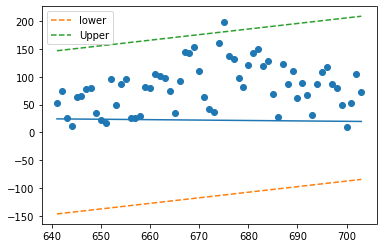

In [43]:
# ref: https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

upper, lower = [], []
for i in range(len(x_test)):
    lower.append(get_prediction_interval(i,y_test, lr_pred_test)[0])
    upper.append(get_prediction_interval(i,y_test, lr_pred_test)[2])

plt.scatter(x_test,y_test)
plt.plot(x_test,lr_pred_test)
plt.plot(x_test,lower,'--',label='lower')
plt.plot(x_test,upper,'--',label='Upper')
plt.legend(loc='upper left')

### Illinois state deaths Forecast

In [44]:
IL_day1_deaths_m.tail()

,day_count,New deaths
752,699,50.0
753,700,9.0
754,701,53.0
755,702,105.0
756,703,73.0


In [45]:
future_dates= np.arange(703,713)

In [46]:
future_dates

array([703, 704, 705, 706, 707, 708, 709, 710, 711, 712])

In [47]:
#predicting the values for future dates
future_predicted_deaths=polynomial_rg.predict(future_dates.reshape(-1,1))
future_predicted_deaths

array([191.34898991, 194.1982677 , 197.07673455, 199.98455497,
       202.92189391, 205.88891671, 208.88578914, 211.91267737,
       214.969748  , 218.05716803])

Text(0.5, 1.0, 'future predications for given dates')

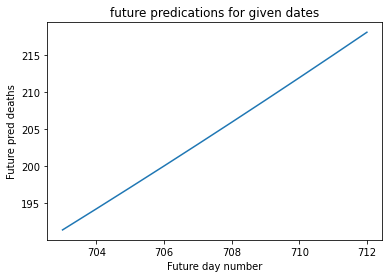

In [48]:
#plotting the predcition path for future dates
plt.plot(future_dates,future_predicted_deaths)
plt.xlabel('Future day number')
plt.ylabel('Future pred deaths')
plt.title("future predications for given dates")

# From Stage 2 Top 5 Counties are :

1. Cass County
2. Vermilion County
3. Brown County
4. Clay County
5. Johnson County

In [49]:
#getting the top 5 counties with hgh infected rate of cases from stage 2
top5_counties=IL_data[IL_data['County Name'].isin(['Cass County ', 'Vermilion County ', 'Brown County ',
       'Clay County ', 'Johnson County '])]

# Cass County

In [50]:
#getting the cass county data
cass=top5_counties[top5_counties['County Name']=='Cass County ']

In [51]:
#getting the requries variables and resetting the index
cass=cass[['Date','New cases','New deaths']]
cass.reset_index(inplace=True,drop=True)
cass

,Date,New cases,New deaths
0,2020-01-23,0.0,0.0
1,2020-01-24,0.0,0.0
2,2020-01-25,0.0,0.0
3,2020-01-26,0.0,0.0
4,2020-01-27,0.0,0.0
...,...,...,...
752,2022-02-13,1.0,1.0
753,2022-02-14,1.0,0.0
754,2022-02-15,1.0,0.0
755,2022-02-16,4.0,0.0


In [52]:
#getting the index of the occurance of first case and first death in the county
cass_case_index= cass['New cases'].ne(0).idxmax() 
cass_death_index= cass['New deaths'].ne(0).idxmax()
print('first case index is',cass_case_index)
print('first death index is',cass_death_index)


first case index is 88
first death index is 155


In [53]:
#removinf the rows before the first day of case and deat occurance in data
cass_day1_cases=cass[['Date','New cases']][cass_case_index:]
cass_day1_deaths=cass[['Date','New deaths']][cass_death_index:]

In [54]:
print('shape',cass_day1_cases.shape)
cass_day1_cases.tail(3)


shape (669, 2)


,Date,New cases
754,2022-02-15,1.0
755,2022-02-16,4.0
756,2022-02-17,9.0


In [55]:
print('shape',cass_day1_deaths.shape)
cass_day1_deaths.tail(3)

shape (602, 2)


,Date,New deaths
754,2022-02-15,0.0
755,2022-02-16,0.0
756,2022-02-17,0.0


In [56]:
#gtting the count of days from isrt day os case occurance
cass_day1_cases['day_count']=''
c=cass_case_index
for i in range(1,cass_day1_cases.shape[0]+1):
    cass_day1_cases['day_count'][c]=i
    c=c+1

#displayig the data with day count    
cass_day1_cases.tail()


,Date,New cases,day_count
752,2022-02-13,1.0,665
753,2022-02-14,1.0,666
754,2022-02-15,1.0,667
755,2022-02-16,4.0,668
756,2022-02-17,9.0,669


In [57]:
#gtting the count of days from fisrt day of death occurance
cass_day1_deaths['day_count']=''
d=cass_death_index
for i in range(1,cass_day1_deaths.shape[0]+1):
    cass_day1_deaths['day_count'][d]=i
    d=d+1

#displayig the data with day count    
cass_day1_deaths[:100]

,Date,New deaths,day_count
155,2020-06-26,1.0,1
156,2020-06-27,0.0,2
157,2020-06-28,0.0,3
158,2020-06-29,0.0,4
159,2020-06-30,1.0,5
...,...,...,...
250,2020-09-29,0.0,96
251,2020-09-30,0.0,97
252,2020-10-01,0.0,98
253,2020-10-02,0.0,99


## Linear regression for Cases 

In [58]:
#getting teh only cases, deaths and day count in the table for model
cass_day1_cases_m =cass_day1_cases[['day_count','New cases']]

In [59]:
cass_day1_cases_m.tail()

,day_count,New cases
752,665,1.0
753,666,1.0
754,667,1.0
755,668,4.0
756,669,9.0


In [60]:
#getting the value of 10 percent o total data for testing
round((cass_day1_cases_m.shape[0]/100)*10)

67

In [61]:
#splitting the data into tain test
x_train=cass_day1_cases_m['day_count'][:cass_day1_cases.shape[0]-67]
y_train=cass_day1_cases_m['New cases'][:cass_day1_cases.shape[0]-67]

#test data
x_test=cass_day1_cases_m['day_count'][cass_day1_cases.shape[0]-67:]
y_test=cass_day1_cases_m['New cases'][cass_day1_cases.shape[0]-67:]


In [62]:
#getting the data for x and y independently
x_train = np.array(x_train).reshape(-1,1)
x_test = np.array(x_test).reshape(-1,1)


In [63]:
#fitting the Linear regression model
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [64]:
#predicting the values for the test data
lr_pred_test = lr.predict(x_test)
lr_pred_test

array([4.9519682 , 4.95239842, 4.95282863, 4.95325884, 4.95368905,
       4.95411927, 4.95454948, 4.95497969, 4.9554099 , 4.95584012,
       4.95627033, 4.95670054, 4.95713075, 4.95756097, 4.95799118,
       4.95842139, 4.9588516 , 4.95928182, 4.95971203, 4.96014224,
       4.96057245, 4.96100267, 4.96143288, 4.96186309, 4.9622933 ,
       4.96272352, 4.96315373, 4.96358394, 4.96401415, 4.96444437,
       4.96487458, 4.96530479, 4.965735  , 4.96616522, 4.96659543,
       4.96702564, 4.96745585, 4.96788607, 4.96831628, 4.96874649,
       4.9691767 , 4.96960692, 4.97003713, 4.97046734, 4.97089755,
       4.97132777, 4.97175798, 4.97218819, 4.9726184 , 4.97304862,
       4.97347883, 4.97390904, 4.97433925, 4.97476947, 4.97519968,
       4.97562989, 4.9760601 , 4.97649032, 4.97692053, 4.97735074,
       4.97778095, 4.97821117, 4.97864138, 4.97907159, 4.9795018 ,
       4.97993202, 4.98036223])

In [65]:
rmse = sqrt(mean_squared_error(y_test, lr_pred_test))
rmse

33.1260400548033

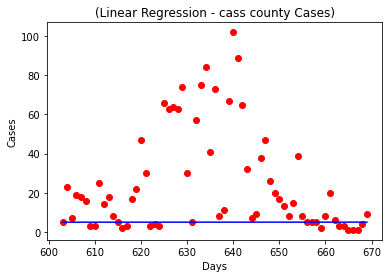

In [66]:
#plotting for linear regression for cass county  cases
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test, lr_pred_test, color='blue')
plt.title('(Linear Regression - cass county Cases)')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.show()

## Polynomial Regression for Cases

RMSE for degree 1 is 33.1260400548033
RMSE for degree 2 is 35.13932505173838
RMSE for degree 3 is 30.334199040802314
RMSE for degree 4 is 29.106810590741084


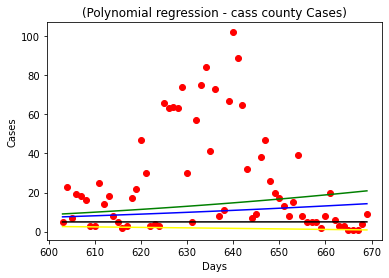

In [67]:
#performing polynomial regression for the cass county
degree=1
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict1 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict1))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=2
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict2 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict2))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=3
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict3 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict3))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=4
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict4 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict4))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))


#PLotting th graph for all 4 degrees for polynomial regression
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test,poly_test_predict1 , color='black')
plt.plot(x_test,poly_test_predict2 , color='yellow')
plt.plot(x_test,poly_test_predict3 , color='blue')
plt.plot(x_test,poly_test_predict4 , color='green')
plt.title('(Polynomial regression - cass county Cases)')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.show()

### Confidence interval for CASS county cases

As rmse for the ploynomial degree 4 is least when compared to linear and polynomial other 3 degrees we considered plotting confidence interval for degree 4 polynomial

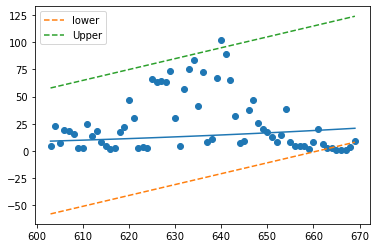

In [68]:
# ref: https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

upper, lower = [], []
for i in range(len(x_test)):
    lower.append(get_prediction_interval(i,y_test, poly_test_predict4)[0])
    upper.append(get_prediction_interval(i,y_test, poly_test_predict4)[2])

plt.scatter(x_test,y_test)
plt.plot(x_test,poly_test_predict4)
plt.plot(x_test,lower,'--',label='lower')
plt.plot(x_test,upper,'--',label='Upper')
plt.legend(loc='upper left')

### Cass County cases Forecast

In [69]:
cass_day1_cases_m.tail()

,day_count,New cases
752,665,1.0
753,666,1.0
754,667,1.0
755,668,4.0
756,669,9.0


In [70]:
future_dates= np.arange(669,679)

In [71]:
future_dates

array([669, 670, 671, 672, 673, 674, 675, 676, 677, 678])

In [72]:
#predicting the values for future dates
future_predicted_cases=polynomial_rg.predict(future_dates.reshape(-1,1))

Text(0.5, 1.0, 'future predications for given dates')

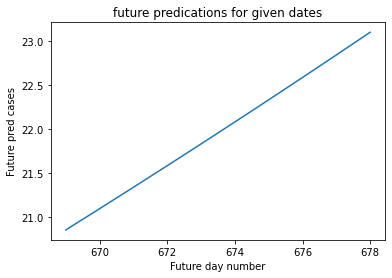

In [73]:
#plotting the trend line for future predicted cases
plt.plot(future_dates,future_predicted_cases)
plt.xlabel('Future day number')
plt.ylabel('Future pred cases')
plt.title("future predications for given dates")

## Linear regression for Deaths

In [74]:
#getting teh only deaths, deaths and day count in the table for model
cass_day1_deaths_m =cass_day1_deaths[['day_count','New deaths']]

In [75]:
cass_day1_deaths_m.tail()

,day_count,New deaths
752,598,1.0
753,599,0.0
754,600,0.0
755,601,0.0
756,602,0.0


In [76]:
#getting the vlaue of 10 percent of total data for testing
round(cass_day1_deaths_m.shape[0]/100)*10

60

In [77]:
#splitting the data into tain test
x_train=cass_day1_deaths_m['day_count'][:cass_day1_deaths_m.shape[0]-30]
y_train=cass_day1_deaths_m['New deaths'][:cass_day1_deaths_m.shape[0]-30]

#test data
x_test=cass_day1_deaths_m['day_count'][cass_day1_deaths_m.shape[0]-30:]
y_test=cass_day1_deaths_m['New deaths'][cass_day1_deaths_m.shape[0]-30:]


In [78]:
#getting the data for x and y independently
x_train = np.array(x_train).reshape(-1,1)
x_test = np.array(x_test).reshape(-1,1)


In [79]:
#fitting the Linear regression model
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [80]:
#predicting the values for the test data
lr_pred_test = lr.predict(x_test)
lr_pred_test

array([ 2.73719275e-03,  2.47215214e-03,  2.20711153e-03,  1.94207091e-03,
        1.67703030e-03,  1.41198968e-03,  1.14694907e-03,  8.81908457e-04,
        6.16867843e-04,  3.51827229e-04,  8.67866145e-05, -1.78254000e-04,
       -4.43294614e-04, -7.08335228e-04, -9.73375842e-04, -1.23841646e-03,
       -1.50345707e-03, -1.76849768e-03, -2.03353830e-03, -2.29857891e-03,
       -2.56361953e-03, -2.82866014e-03, -3.09370075e-03, -3.35874137e-03,
       -3.62378198e-03, -3.88882260e-03, -4.15386321e-03, -4.41890382e-03,
       -4.68394444e-03, -4.94898505e-03])

In [81]:
rmse = sqrt(mean_squared_error(y_test, lr_pred_test))
rmse

0.316434010993109

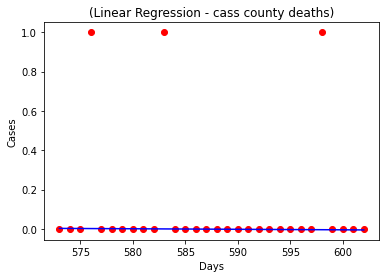

In [82]:
#plotting for linear regression for ILLINOIS state deaths
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test, lr_pred_test, color='blue')
plt.title('(Linear Regression - cass county deaths)')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.show()

## Polynomial Regression for Deaths

RMSE for degree 1 is 0.316434010993109
RMSE for degree 2 is 0.3059880395489304
RMSE for degree 3 is 0.31153627294926634
RMSE for degree 4 is 0.30183306802071536


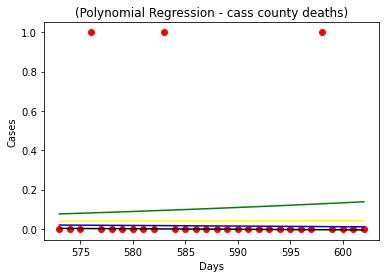

In [83]:
#polynomial regression for Cass county  deaths

degree=1
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict1 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict1))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=2
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict2 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict2))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=3
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict3 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict3))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=4
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict4 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict4))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

#ploting for all 4 degrees for polynomial regression 
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test,poly_test_predict1 , color='black')
plt.plot(x_test,poly_test_predict2 , color='yellow')
plt.plot(x_test,poly_test_predict3 , color='blue')
plt.plot(x_test,poly_test_predict4 , color='green')
plt.title('(Polynomial Regression - cass county deaths)')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.show()

### Confidence interval for cass county deaths

As rmse for the ploynomial degree 2 is least when compared to linear and polynomial other 3 degrees we considered plotting confidence interval for degree 2 polynomial

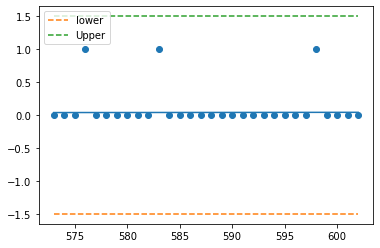

In [84]:
# ref: https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

upper, lower = [], []
for i in range(len(x_test)):
    lower.append(get_prediction_interval(i,y_test, poly_test_predict2)[0])
    upper.append(get_prediction_interval(i,y_test, poly_test_predict2)[2])
    
upper=[1.5]*len(upper)
lower=[-1.5]*len(lower)
plt.scatter(x_test,y_test)
plt.plot(x_test,poly_test_predict2)
plt.plot(x_test,lower,'--',label='lower')
plt.plot(x_test,upper,'--',label='Upper')
plt.legend(loc='upper left')

### Cass County deaths Forecast

In [85]:
cass_day1_deaths_m.tail()

,day_count,New deaths
752,598,1.0
753,599,0.0
754,600,0.0
755,601,0.0
756,602,0.0


In [86]:
future_dates= np.arange(602,612)
future_dates

array([602, 603, 604, 605, 606, 607, 608, 609, 610, 611])

In [87]:
#predicting the values for future dates
future_predicted_deaths=polynomial_rg.predict(future_dates.reshape(-1,1))

Text(0.5, 1.0, 'future predications for given dates')

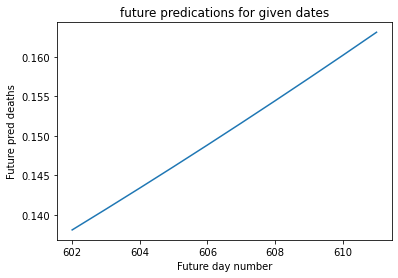

In [88]:
#plotting the trend line for future predicted cases
plt.plot(future_dates,future_predicted_deaths)
plt.xlabel('Future day number')
plt.ylabel('Future pred deaths')
plt.title("future predications for given dates")

# Vermilion County

In [89]:
#getting the Vermilion  county data
Vermilion =top5_counties[top5_counties['County Name']=='Vermilion County ']

In [90]:
#getting the requries variables and resetting the index
Vermilion=Vermilion[['Date','New cases','New deaths']]
Vermilion.reset_index(inplace=True,drop=True)
Vermilion

,Date,New cases,New deaths
0,2020-01-23,0.0,0.0
1,2020-01-24,0.0,0.0
2,2020-01-25,0.0,0.0
3,2020-01-26,0.0,0.0
4,2020-01-27,0.0,0.0
...,...,...,...
752,2022-02-13,18.0,1.0
753,2022-02-14,11.0,0.0
754,2022-02-15,17.0,2.0
755,2022-02-16,34.0,2.0


In [91]:
#getting the index of the occurance of first case and first death in the county
Vermilion_case_index= Vermilion['New cases'].ne(0).idxmax() 
Vermilion_death_index= Vermilion['New deaths'].ne(0).idxmax()
print('first case index is',Vermilion_case_index)
print('first death index is',Vermilion_death_index)


first case index is 69
first death index is 97


In [92]:
 #removing the rows before the first day of case and deat occurance in data
Vermilion_day1_cases=Vermilion[['Date','New cases']][Vermilion_case_index:]
Vermilion_day1_deaths=Vermilion[['Date','New deaths']][Vermilion_death_index:]

In [93]:
print('shape',Vermilion_day1_cases.shape)
Vermilion_day1_cases.tail(3)

shape (688, 2)


,Date,New cases
754,2022-02-15,17.0
755,2022-02-16,34.0
756,2022-02-17,12.0


In [94]:
print('shape',Vermilion_day1_deaths.shape)
Vermilion_day1_deaths.tail(3)

shape (660, 2)


,Date,New deaths
754,2022-02-15,2.0
755,2022-02-16,2.0
756,2022-02-17,1.0


In [95]:
#gtting the count of days from isrt day os case occurance
Vermilion_day1_cases['day_count']=''
c=Vermilion_case_index
for i in range(1,Vermilion_day1_cases.shape[0]+1):
    Vermilion_day1_cases['day_count'][c]=i
    c=c+1

#displayig the data with day count    
Vermilion_day1_cases.tail()


,Date,New cases,day_count
752,2022-02-13,18.0,684
753,2022-02-14,11.0,685
754,2022-02-15,17.0,686
755,2022-02-16,34.0,687
756,2022-02-17,12.0,688


In [96]:
#gtting the count of days from fisrt day of death occurance
Vermilion_day1_deaths['day_count']=''
d=Vermilion_death_index
for i in range(1,Vermilion_day1_deaths.shape[0]+1):
    Vermilion_day1_deaths['day_count'][d]=i
    d=d+1

#displayig the data with day count    
Vermilion_day1_deaths.tail()

,Date,New deaths,day_count
752,2022-02-13,1.0,656
753,2022-02-14,0.0,657
754,2022-02-15,2.0,658
755,2022-02-16,2.0,659
756,2022-02-17,1.0,660


### Linear regression for Cases

In [97]:
#getting teh only cases, deaths and day count in the table for model
Vermilion_day1_cases_m =Vermilion_day1_cases[['day_count','New cases']]

In [98]:
Vermilion_day1_cases_m.tail()

,day_count,New cases
752,684,18.0
753,685,11.0
754,686,17.0
755,687,34.0
756,688,12.0


In [99]:
#getting the 10 percen value for testing data
round((Vermilion_day1_cases_m.shape[0]/100)*10)

69

In [100]:
#splitting the data into tain test
x_train=Vermilion_day1_cases_m['day_count'][:Vermilion_day1_cases.shape[0]-69]
y_train=Vermilion_day1_cases_m['New cases'][:Vermilion_day1_cases.shape[0]-69]

#test data
x_test=Vermilion_day1_cases_m['day_count'][Vermilion_day1_cases.shape[0]-69:]
y_test=Vermilion_day1_cases_m['New cases'][Vermilion_day1_cases.shape[0]-69:]


In [101]:
#getting the data for x and y independently
x_train = np.array(x_train).reshape(-1,1)
x_test = np.array(x_test).reshape(-1,1)


In [102]:
#fitting the Linear regression model
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [103]:
#predicting the values for the test data
lr_pred_test = lr.predict(x_test)
lr_pred_test

array([49.22999827, 49.29812256, 49.36624684, 49.43437113, 49.50249541,
       49.5706197 , 49.63874398, 49.70686827, 49.77499255, 49.84311683,
       49.91124112, 49.9793654 , 50.04748969, 50.11561397, 50.18373826,
       50.25186254, 50.31998682, 50.38811111, 50.45623539, 50.52435968,
       50.59248396, 50.66060825, 50.72873253, 50.79685682, 50.8649811 ,
       50.93310538, 51.00122967, 51.06935395, 51.13747824, 51.20560252,
       51.27372681, 51.34185109, 51.40997538, 51.47809966, 51.54622394,
       51.61434823, 51.68247251, 51.7505968 , 51.81872108, 51.88684537,
       51.95496965, 52.02309393, 52.09121822, 52.1593425 , 52.22746679,
       52.29559107, 52.36371536, 52.43183964, 52.49996393, 52.56808821,
       52.63621249, 52.70433678, 52.77246106, 52.84058535, 52.90870963,
       52.97683392, 53.0449582 , 53.11308249, 53.18120677, 53.24933105,
       53.31745534, 53.38557962, 53.45370391, 53.52182819, 53.58995248,
       53.65807676, 53.72620104, 53.79432533, 53.86244961])

In [104]:
rmse = sqrt(mean_squared_error(y_test, lr_pred_test))
rmse

152.3084590952631

### Trend Line

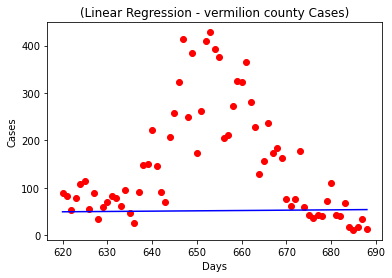

In [105]:
#plotting for linear regression for vermilion county  cases
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test, lr_pred_test, color='blue')
plt.title('(Linear Regression - vermilion county Cases)')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.show()

### Polynomial Regression for Cases

RMSE for degree 1 is 152.30845909526312
RMSE for degree 2 is 155.7392825623117
RMSE for degree 3 is 127.59252822381627
RMSE for degree 4 is 129.96355244654322


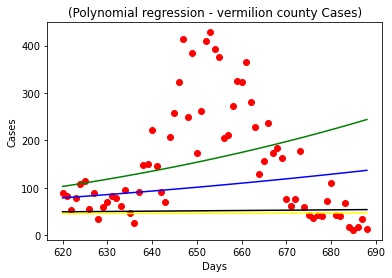

In [106]:
#performing polynomial regression for the vermilion county
degree=1
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict1 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict1))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=2
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict2 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict2))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=3
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict3 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict3))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=4
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict4 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict4))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))


#PLotting th graph for all 4 degrees for polynomial regression
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test,poly_test_predict1 , color='black')
plt.plot(x_test,poly_test_predict2 , color='yellow')
plt.plot(x_test,poly_test_predict3 , color='blue')
plt.plot(x_test,poly_test_predict4 , color='green')
plt.title('(Polynomial regression - vermilion county Cases)')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.show()

### Confidence interval for vermilion cases

As rmse for the ploynomial degree 4 is least when compared to linear and polynomial other 3 degrees we considered plotting confidence interval for degree 4 polynomial

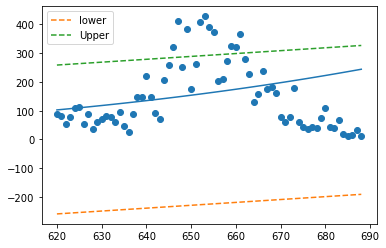

In [107]:
# ref: https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

upper, lower = [], []
for i in range(len(x_test)):
    lower.append(get_prediction_interval(i,y_test, poly_test_predict4)[0])
    upper.append(get_prediction_interval(i,y_test, poly_test_predict4)[2])

plt.scatter(x_test,y_test)
plt.plot(x_test,poly_test_predict4)
plt.plot(x_test,lower,'--',label='lower')
plt.plot(x_test,upper,'--',label='Upper')
plt.legend(loc='upper left')

### Vermilion County cases Forecast

In [108]:
Vermilion_day1_cases_m.tail()

,day_count,New cases
752,684,18.0
753,685,11.0
754,686,17.0
755,687,34.0
756,688,12.0


In [109]:
future_dates= np.arange(688,698)
future_dates

array([688, 689, 690, 691, 692, 693, 694, 695, 696, 697])

In [110]:
#predicting the values for future dates
future_predicted_cases=lr.predict(future_dates.reshape(-1,1))

Text(0.5, 1.0, 'future predications for given dates')

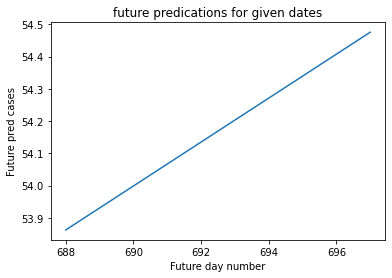

In [111]:
#plotting the trend line for future predicted cases
plt.plot(future_dates,future_predicted_cases)
plt.xlabel('Future day number')
plt.ylabel('Future pred cases')
plt.title("future predications for given dates")

## Linear regression for Deaths

In [112]:
#getting teh only deaths, deaths and day count in the table for model
Vermilion_day1_deaths_m =Vermilion_day1_deaths[['day_count','New deaths']]

In [113]:
Vermilion_day1_deaths_m.tail()

,day_count,New deaths
752,656,1.0
753,657,0.0
754,658,2.0
755,659,2.0
756,660,1.0


In [114]:
#getting the 10 percent value for testing data
round(Vermilion_day1_deaths_m.shape[0]/100*10)

66

In [115]:
#splitting the data into tain test
x_train=Vermilion_day1_deaths_m['day_count'][:Vermilion_day1_deaths_m.shape[0]-66]
y_train=Vermilion_day1_deaths_m['New deaths'][:Vermilion_day1_deaths_m.shape[0]-66]

#test data
x_test=Vermilion_day1_deaths_m['day_count'][Vermilion_day1_deaths_m.shape[0]-66:]
y_test=Vermilion_day1_deaths_m['New deaths'][Vermilion_day1_deaths_m.shape[0]-66:]


In [116]:
#getting the data for x and y independently
x_train = np.array(x_train).reshape(-1,1)
x_test = np.array(x_test).reshape(-1,1)


In [117]:
#fitting the Linear regression model
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [118]:
#predicting the values for the test data
lr_pred_test = lr.predict(x_test)
lr_pred_test

array([0.59072456, 0.5913068 , 0.59188904, 0.59247128, 0.59305352,
       0.59363575, 0.59421799, 0.59480023, 0.59538247, 0.59596471,
       0.59654695, 0.59712919, 0.59771143, 0.59829367, 0.59887591,
       0.59945815, 0.60004038, 0.60062262, 0.60120486, 0.6017871 ,
       0.60236934, 0.60295158, 0.60353382, 0.60411606, 0.6046983 ,
       0.60528054, 0.60586278, 0.60644502, 0.60702725, 0.60760949,
       0.60819173, 0.60877397, 0.60935621, 0.60993845, 0.61052069,
       0.61110293, 0.61168517, 0.61226741, 0.61284965, 0.61343188,
       0.61401412, 0.61459636, 0.6151786 , 0.61576084, 0.61634308,
       0.61692532, 0.61750756, 0.6180898 , 0.61867204, 0.61925428,
       0.61983652, 0.62041875, 0.62100099, 0.62158323, 0.62216547,
       0.62274771, 0.62332995, 0.62391219, 0.62449443, 0.62507667,
       0.62565891, 0.62624115, 0.62682338, 0.62740562, 0.62798786,
       0.6285701 ])

In [119]:
rmse = sqrt(mean_squared_error(y_test, lr_pred_test))
rmse

1.0412255987092727

#### Trend Line

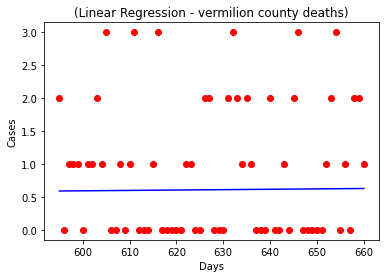

In [120]:
#plotting for linear regression for ILLINOIS state deaths
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test, lr_pred_test, color='blue')
plt.title('(Linear Regression - vermilion county deaths)')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.show()

## Polynomial Regression for Deaths

RMSE for degree 1 is 1.0412255987092727
RMSE for degree 2 is 1.2305680437365933
RMSE for degree 3 is 1.0084572915955112
RMSE for degree 4 is 1.1958854429307284


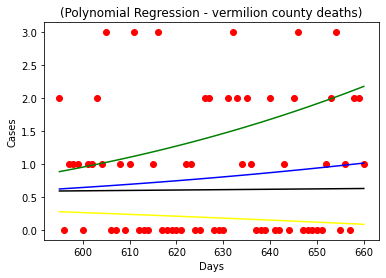

In [121]:
#polynomial regression for vermilion county  deaths

degree=1
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict1 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict1))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=2
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict2 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict2))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=3
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict3 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict3))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=4
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict4 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict4))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

#ploting for all 4 degrees for polynomial regression 
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test,poly_test_predict1 , color='black')
plt.plot(x_test,poly_test_predict2 , color='yellow')
plt.plot(x_test,poly_test_predict3 , color='blue')
plt.plot(x_test,poly_test_predict4 , color='green')
plt.title('(Polynomial Regression - vermilion county deaths)')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.show()

### Confidence interval for vermilion deaths

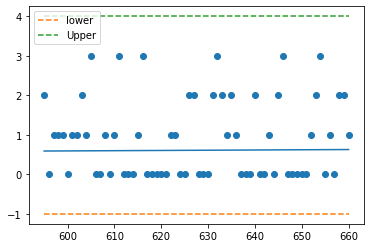

In [122]:
# ref: https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

upper, lower = [], []
for i in range(len(x_test)):
    lower.append(get_prediction_interval(i,y_test, lr_pred_test)[0])
    upper.append(get_prediction_interval(i,y_test, lr_pred_test)[2])
upper=[4]*len(upper)
lower=[-1]*len(lower)
plt.scatter(x_test,y_test)
plt.plot(x_test,lr_pred_test)
plt.plot(x_test,lower,'--',label='lower')
plt.plot(x_test,upper,'--',label='Upper')
plt.legend(loc='upper left')

### Vermilion County deaths Forecast

In [123]:
Vermilion_day1_deaths_m.tail()

,day_count,New deaths
752,656,1.0
753,657,0.0
754,658,2.0
755,659,2.0
756,660,1.0


In [124]:
future_dates= np.arange(661,671)

In [125]:
future_dates

array([661, 662, 663, 664, 665, 666, 667, 668, 669, 670])

In [126]:
#predicting the values for future dates
future_predicted_deaths=lr.predict(future_dates.reshape(-1,1))

Text(0.5, 1.0, 'future predications for given dates')

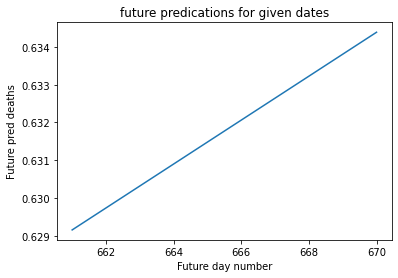

In [127]:
#plotting the trend line for future predicted cases
plt.plot(future_dates,future_predicted_deaths)
plt.xlabel('Future day number')
plt.ylabel('Future pred deaths')
plt.title("future predications for given dates")

# Brown County

In [128]:
#getting the Brown county data
Brown=top5_counties[top5_counties['County Name']=='Brown County ']

In [129]:
#getting the requries variables and resetting the index
Brown=Brown[['Date','New cases','New deaths']]
Brown.reset_index(inplace=True,drop=True)
Brown

,Date,New cases,New deaths
0,2020-01-23,0.0,0.0
1,2020-01-24,0.0,0.0
2,2020-01-25,0.0,0.0
3,2020-01-26,0.0,0.0
4,2020-01-27,0.0,0.0
...,...,...,...
752,2022-02-13,2.0,0.0
753,2022-02-14,1.0,0.0
754,2022-02-15,4.0,0.0
755,2022-02-16,0.0,0.0


In [130]:
#getting the index of the occurance of first case and first death in the county
Brown_case_index= Brown['New cases'].ne(0).idxmax() 
Brown_death_index= Brown['New deaths'].ne(0).idxmax()
print('first case index is',Brown_case_index)
print('first death index is',Brown_death_index)


first case index is 99
first death index is 294


In [131]:
#removing the rows before the first day of case and deat occurance in data
Brown_day1_cases=Brown[['Date','New cases']][Brown_case_index:]
Brown_day1_deaths=Brown[['Date','New deaths']][Brown_death_index:]

In [132]:
print('shape',Brown_day1_cases.shape)
Brown_day1_cases.tail(3)

shape (658, 2)


,Date,New cases
754,2022-02-15,4.0
755,2022-02-16,0.0
756,2022-02-17,2.0


In [133]:
print('shape',Brown_day1_deaths.shape)
Brown_day1_deaths.tail(3)

shape (463, 2)


,Date,New deaths
754,2022-02-15,0.0
755,2022-02-16,0.0
756,2022-02-17,1.0


In [134]:
#gtting the count of days from isrt day os case occurance
Brown_day1_cases['day_count']=''
c=Brown_case_index
for i in range(1,Brown_day1_cases.shape[0]+1):
    Brown_day1_cases['day_count'][c]=i
    c=c+1

#displayig the data with day count    
Brown_day1_cases.tail()


,Date,New cases,day_count
752,2022-02-13,2.0,654
753,2022-02-14,1.0,655
754,2022-02-15,4.0,656
755,2022-02-16,0.0,657
756,2022-02-17,2.0,658


In [135]:
#gtting the count of days from fisrt day of death occurance
Brown_day1_deaths['day_count']=''
d=Brown_death_index
for i in range(1,Brown_day1_deaths.shape[0]+1):
    Brown_day1_deaths['day_count'][d]=i
    d=d+1

#displayig the data with day count    
Brown_day1_deaths.tail()

,Date,New deaths,day_count
752,2022-02-13,0.0,459
753,2022-02-14,0.0,460
754,2022-02-15,0.0,461
755,2022-02-16,0.0,462
756,2022-02-17,1.0,463


## Linear regression for Cases 

In [136]:
#getting teh only cases, deaths and day count in the table for model
Brown_day1_cases_m =Brown_day1_cases[['day_count','New cases']]

In [137]:
Brown_day1_cases_m.tail()

,day_count,New cases
752,654,2.0
753,655,1.0
754,656,4.0
755,657,0.0
756,658,2.0


In [138]:
#getting the 10 percen value for testing data
round((Brown_day1_cases_m.shape[0]/100)*10)

66

In [139]:
#splitting the data into tain test
x_train=Brown_day1_cases_m['day_count'][:Brown_day1_cases.shape[0]-66]
y_train=Brown_day1_cases_m['New cases'][:Brown_day1_cases.shape[0]-66]

#test data
x_test=Brown_day1_cases_m['day_count'][Brown_day1_cases.shape[0]-66:]
y_test=Brown_day1_cases_m['New cases'][Brown_day1_cases.shape[0]-66:]


In [140]:
#getting the data for x and y independently
x_train = np.array(x_train).reshape(-1,1)
x_test = np.array(x_test).reshape(-1,1)


In [141]:
#fitting the Linear regression model
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [142]:
#predicting the values for the test data
lr_pred_test = lr.predict(x_test)
lr_pred_test

array([2.61853478, 2.62064938, 2.62276399, 2.6248786 , 2.6269932 ,
       2.62910781, 2.63122242, 2.63333702, 2.63545163, 2.63756623,
       2.63968084, 2.64179545, 2.64391005, 2.64602466, 2.64813926,
       2.65025387, 2.65236848, 2.65448308, 2.65659769, 2.6587123 ,
       2.6608269 , 2.66294151, 2.66505611, 2.66717072, 2.66928533,
       2.67139993, 2.67351454, 2.67562914, 2.67774375, 2.67985836,
       2.68197296, 2.68408757, 2.68620218, 2.68831678, 2.69043139,
       2.69254599, 2.6946606 , 2.69677521, 2.69888981, 2.70100442,
       2.70311902, 2.70523363, 2.70734824, 2.70946284, 2.71157745,
       2.71369206, 2.71580666, 2.71792127, 2.72003587, 2.72215048,
       2.72426509, 2.72637969, 2.7284943 , 2.7306089 , 2.73272351,
       2.73483812, 2.73695272, 2.73906733, 2.74118194, 2.74329654,
       2.74541115, 2.74752575, 2.74964036, 2.75175497, 2.75386957,
       2.75598418])

In [143]:
rmse = sqrt(mean_squared_error(y_test, lr_pred_test))
rmse

49.96582392914809

#### Trend line

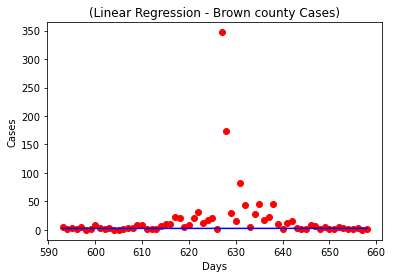

In [144]:
#plotting for linear regression for Brown county  cases
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test, lr_pred_test, color='blue')
plt.title('(Linear Regression - Brown county Cases)')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.show()

## Polynomial Regression for Cases

RMSE for degree 1 is 49.96582392914809
RMSE for degree 2 is 50.56460656929865
RMSE for degree 3 is 49.6160023600729
RMSE for degree 4 is 49.39362710090286


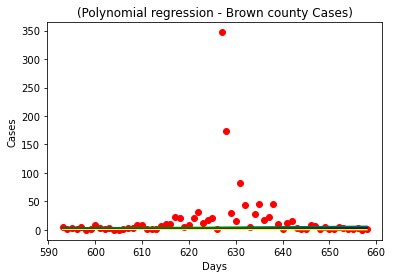

In [145]:
#performing polynomial regression for the Brown county
degree=1
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict1 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict1))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=2
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict2 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict2))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=3
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict3 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict3))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=4
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict4 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict4))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))


#PLotting th graph for all 4 degrees for polynomial regression
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test,poly_test_predict1 , color='black')
plt.plot(x_test,poly_test_predict2 , color='yellow')
plt.plot(x_test,poly_test_predict3 , color='blue')
plt.plot(x_test,poly_test_predict4 , color='green')
plt.title('(Polynomial regression - Brown county Cases)')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.show()

### confidence interval for brown county cases

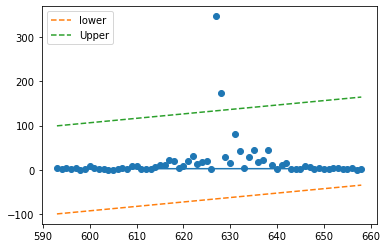

In [146]:
# ref: https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

upper, lower = [], []
for i in range(len(x_test)):
    lower.append(get_prediction_interval(i,y_test, lr_pred_test)[0])
    upper.append(get_prediction_interval(i,y_test, lr_pred_test)[2])

plt.scatter(x_test,y_test)
plt.plot(x_test,lr_pred_test)
plt.plot(x_test,lower,'--',label='lower')
plt.plot(x_test,upper,'--',label='Upper')
plt.legend(loc='upper left')

### Brown County cases Forecast

In [147]:
Brown_day1_cases_m.tail()

,day_count,New cases
752,654,2.0
753,655,1.0
754,656,4.0
755,657,0.0
756,658,2.0


In [148]:
future_dates= np.arange(658,668)

In [149]:
future_dates

array([658, 659, 660, 661, 662, 663, 664, 665, 666, 667])

In [150]:
#predicting the values for future dates
future_predicted_cases=lr.predict(future_dates.reshape(-1,1))

Text(0.5, 1.0, 'future predications for given dates')

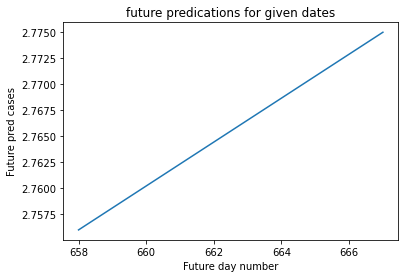

In [151]:
#plotting the trend line for future predicted cases
plt.plot(future_dates,future_predicted_cases)
plt.xlabel('Future day number')
plt.ylabel('Future pred cases')
plt.title("future predications for given dates")

## Linear regression for Deaths

In [152]:
#getting teh only deaths, deaths and day count in the table for model
Brown_day1_deaths_m =Brown_day1_deaths[['day_count','New deaths']]

In [153]:
max(Brown_day1_deaths_m["New deaths"])

2.0

In [154]:
Brown_day1_deaths_m.tail()

,day_count,New deaths
752,459,0.0
753,460,0.0
754,461,0.0
755,462,0.0
756,463,1.0


In [155]:
#getting the 10 percen value for testing data
round((Brown_day1_deaths_m.shape[0]/100)*10)

46

In [156]:
#splitting the data into tain test
x_train=Brown_day1_deaths_m['day_count'][:Brown_day1_deaths_m.shape[0]-46]
y_train=Brown_day1_deaths_m['New deaths'][:Brown_day1_deaths_m.shape[0]-46]

#test data
x_test=Brown_day1_deaths_m['day_count'][Brown_day1_deaths_m.shape[0]-46:]
y_test=Brown_day1_deaths_m['New deaths'][Brown_day1_deaths_m.shape[0]-46:]


In [157]:
#getting the data for x and y independently
x_train = np.array(x_train).reshape(-1,1)
x_test = np.array(x_test).reshape(-1,1)


In [158]:
#fitting the Linear regression model
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [159]:
#predicting the values for the test data
lr_pred_test = lr.predict(x_test)
lr_pred_test

array([-0.00549945, -0.00573229, -0.00596514, -0.00619799, -0.00643083,
       -0.00666368, -0.00689653, -0.00712937, -0.00736222, -0.00759506,
       -0.00782791, -0.00806076, -0.0082936 , -0.00852645, -0.0087593 ,
       -0.00899214, -0.00922499, -0.00945784, -0.00969068, -0.00992353,
       -0.01015638, -0.01038922, -0.01062207, -0.01085492, -0.01108776,
       -0.01132061, -0.01155346, -0.0117863 , -0.01201915, -0.01225199,
       -0.01248484, -0.01271769, -0.01295053, -0.01318338, -0.01341623,
       -0.01364907, -0.01388192, -0.01411477, -0.01434761, -0.01458046,
       -0.01481331, -0.01504615, -0.015279  , -0.01551185, -0.01574469,
       -0.01597754])

In [160]:
rmse = sqrt(mean_squared_error(y_test, lr_pred_test))
rmse

0.2119472027310547

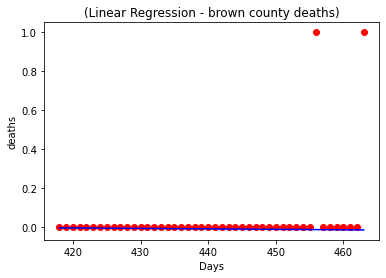

In [161]:
#plotting for linear regression for brown county  deaths
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test, lr_pred_test, color='blue')
plt.title('(Linear Regression - brown county deaths)')
plt.xlabel('Days')
plt.ylabel('deaths')
plt.show()

## Polynomial Regression for Deaths

RMSE for degree 1 is 0.2119472027310547
RMSE for degree 2 is 0.21727404629655792
RMSE for degree 3 is 0.23612752546717852
RMSE for degree 4 is 0.20467569638696714


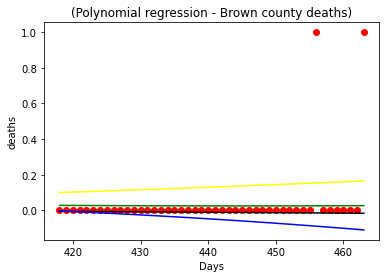

In [162]:
#performing polynomial regression for the Brown county
degree=1
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict1 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict1))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=2
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict2 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict2))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=3
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict3 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict3))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=4
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict4 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict4))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))


#PLotting th graph for all 4 degrees for polynomial regression
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test,poly_test_predict1 , color='black')
plt.plot(x_test,poly_test_predict2 , color='yellow')
plt.plot(x_test,poly_test_predict3 , color='blue')
plt.plot(x_test,poly_test_predict4 , color='green')
plt.title('(Polynomial regression - Brown county deaths)')
plt.xlabel('Days')
plt.ylabel('deaths')
plt.show()

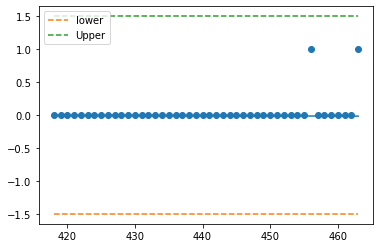

In [163]:
# ref: https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

upper, lower = [], []
for i in range(len(x_test)):
    lower.append(get_prediction_interval(i,y_test, lr_pred_test)[0])
    upper.append(get_prediction_interval(i,y_test, lr_pred_test)[2])

upper=[1.5]*len(upper)
lower=[-1.5]*len(lower)

plt.scatter(x_test,y_test)
plt.plot(x_test,lr_pred_test)
plt.plot(x_test,lower,'--',label='lower')
plt.plot(x_test,upper,'--',label='Upper')
plt.legend(loc='upper left')

### Brown County deaths Forecast

In [164]:
Brown_day1_deaths_m.tail()

,day_count,New deaths
752,459,0.0
753,460,0.0
754,461,0.0
755,462,0.0
756,463,1.0


In [165]:
future_dates= np.arange(464,475)

In [166]:
future_dates

array([464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474])

In [167]:
#predicting the values for future dates
future_predicted_deaths=lr.predict(future_dates.reshape(-1,1))

Text(0.5, 1.0, 'future predications for given dates')

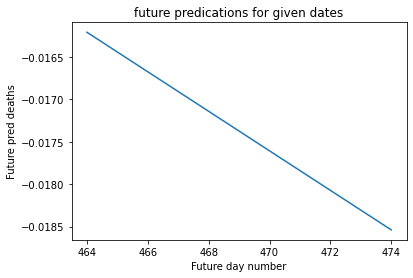

In [168]:
#plotting the trend line for future predicted cases
plt.plot(future_dates,future_predicted_deaths)
plt.xlabel('Future day number')
plt.ylabel('Future pred deaths')
plt.title("future predications for given dates")

# Clay County

In [169]:
#getting the Clay county data
Clay=top5_counties[top5_counties['County Name']=='Clay County ']

In [170]:
#getting the requries variables and resetting the index
Clay=Clay[['Date','New cases','New deaths']]
Clay.reset_index(inplace=True,drop=True)
Clay

,Date,New cases,New deaths
0,2020-01-23,0.0,0.0
1,2020-01-24,0.0,0.0
2,2020-01-25,0.0,0.0
3,2020-01-26,0.0,0.0
4,2020-01-27,0.0,0.0
...,...,...,...
752,2022-02-13,3.0,0.0
753,2022-02-14,4.0,0.0
754,2022-02-15,1.0,0.0
755,2022-02-16,12.0,0.0


In [171]:
#getting the index of the occurance of first case and first death in the county
Clay_case_index= Clay['New cases'].ne(0).idxmax() 
Clay_death_index= Clay['New deaths'].ne(0).idxmax()
print('first case index is',Clay_case_index)
print('first death index is',Clay_death_index)


first case index is 82
first death index is 259


In [172]:
#removinf the rows before the first day of case and deat occurance in data
Clay_day1_cases=Clay[['Date','New cases']][Clay_case_index:]
Clay_day1_deaths=Clay[['Date','New deaths']][Clay_death_index:]

In [173]:
print('shape',Clay_day1_cases.shape)
Clay_day1_cases.tail(3)


shape (675, 2)


,Date,New cases
754,2022-02-15,1.0
755,2022-02-16,12.0
756,2022-02-17,7.0


In [174]:
print('shape',Clay_day1_deaths.shape)

Clay_day1_deaths.tail(3)

shape (498, 2)


,Date,New deaths
754,2022-02-15,0.0
755,2022-02-16,0.0
756,2022-02-17,0.0


In [175]:
#gtting the count of days from isrt day os case occurance
Clay_day1_cases['day_count']=''
c=Clay_case_index
for i in range(1,Clay_day1_cases.shape[0]+1):
    Clay_day1_cases['day_count'][c]=i
    c=c+1

#displayig the data with day count    
Clay_day1_cases.tail()


,Date,New cases,day_count
752,2022-02-13,3.0,671
753,2022-02-14,4.0,672
754,2022-02-15,1.0,673
755,2022-02-16,12.0,674
756,2022-02-17,7.0,675


In [176]:
#gtting the count of days from fisrt day of death occurance
Clay_day1_deaths['day_count']=''
d=Clay_death_index
for i in range(1,Clay_day1_deaths.shape[0]+1):
    Clay_day1_deaths['day_count'][d]=i
    d=d+1

#displayig the data with day count    
Clay_day1_deaths.tail()

,Date,New deaths,day_count
752,2022-02-13,0.0,494
753,2022-02-14,0.0,495
754,2022-02-15,0.0,496
755,2022-02-16,0.0,497
756,2022-02-17,0.0,498


## Linear regression for Cases 

In [177]:
#getting teh only cases, deaths and day count in the table for model
Clay_day1_cases_m =Clay_day1_cases[['day_count','New cases']]

In [178]:
Clay_day1_cases_m.tail()

,day_count,New cases
752,671,3.0
753,672,4.0
754,673,1.0
755,674,12.0
756,675,7.0


In [179]:
#getting the 10 percen value for testing data
round((Clay_day1_cases_m.shape[0]/100)*10)

68

In [180]:
#splitting the data into tain test
x_train=Clay_day1_cases_m['day_count'][:Clay_day1_cases.shape[0]-68]
y_train=Clay_day1_cases_m['New cases'][:Clay_day1_cases.shape[0]-68]

#test data
x_test=Clay_day1_cases_m['day_count'][Clay_day1_cases.shape[0]-68:]
y_test=Clay_day1_cases_m['New cases'][Clay_day1_cases.shape[0]-68:]


In [181]:
y_test.shape

(68,)

In [182]:
#getting the data for x and y independently
x_train = np.array(x_train).reshape(-1,1)
x_test = np.array(x_test).reshape(-1,1)


In [183]:
#fitting the Linear regression model
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [184]:
#predicting the values for the test data
lr_pred_test = lr.predict(x_test)
lr_pred_test

array([9.05154387, 9.06462203, 9.07770019, 9.09077836, 9.10385652,
       9.11693468, 9.13001284, 9.14309101, 9.15616917, 9.16924733,
       9.18232549, 9.19540365, 9.20848182, 9.22155998, 9.23463814,
       9.2477163 , 9.26079447, 9.27387263, 9.28695079, 9.30002895,
       9.31310711, 9.32618528, 9.33926344, 9.3523416 , 9.36541976,
       9.37849793, 9.39157609, 9.40465425, 9.41773241, 9.43081058,
       9.44388874, 9.4569669 , 9.47004506, 9.48312322, 9.49620139,
       9.50927955, 9.52235771, 9.53543587, 9.54851404, 9.5615922 ,
       9.57467036, 9.58774852, 9.60082669, 9.61390485, 9.62698301,
       9.64006117, 9.65313933, 9.6662175 , 9.67929566, 9.69237382,
       9.70545198, 9.71853015, 9.73160831, 9.74468647, 9.75776463,
       9.77084279, 9.78392096, 9.79699912, 9.81007728, 9.82315544,
       9.83623361, 9.84931177, 9.86238993, 9.87546809, 9.88854626,
       9.90162442, 9.91470258, 9.92778074])

In [185]:
rmse = sqrt(mean_squared_error(y_test, lr_pred_test))
rmse

24.467722173072673

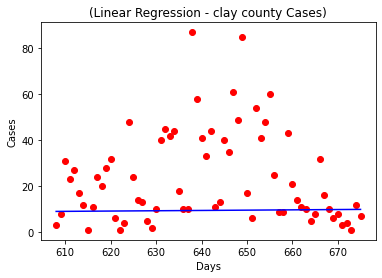

In [186]:
#plotting for linear regression for Clay county  cases
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test, lr_pred_test, color='blue')
plt.title('(Linear Regression - clay county Cases)')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.show()

## Polynomial Regression for Cases

In [187]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [188]:
for degree in [1,2,3,4]:
    polynomial_rg = PolynomialRegression(degree)
    polynomial_rg.fit(x_train, y_train)
    poly_test_predict =polynomial_rg.predict(x_test)
    polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict))
    print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

RMSE for degree 1 is 24.467722173072673
RMSE for degree 2 is 24.14484060441135
RMSE for degree 3 is 20.62042361657503
RMSE for degree 4 is 20.67594419424148


RMSE for degree 1 is 24.467722173072673
RMSE for degree 2 is 24.14484060441135
RMSE for degree 3 is 20.62042361657503
RMSE for degree 4 is 20.67594419424148


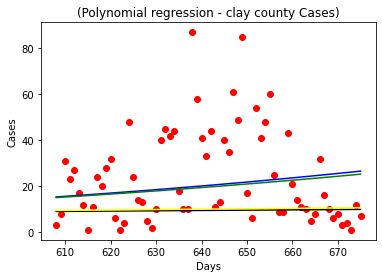

In [189]:
#performing polynomial regression for the clay county
degree=1
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict1 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict1))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=2
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict2 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict2))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=3
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict3 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict3))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=4
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict4 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict4))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))


#PLotting th graph for all 4 degrees for polynomial regression
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test,poly_test_predict1 , color='black')
plt.plot(x_test,poly_test_predict2 , color='yellow')
plt.plot(x_test,poly_test_predict3 , color='blue')
plt.plot(x_test,poly_test_predict4 , color='green')
plt.title('(Polynomial regression - clay county Cases)')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.show()

### confidence interval for clay county cases


As rmse for the ploynomial degree 4 is least when compared to linear and polynomial other 3 degrees we considered plotting confidence interval for degree 4 polynomial

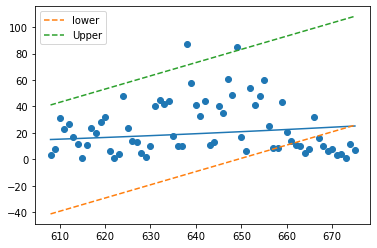

In [190]:
# ref: https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

upper, lower = [], []
for i in range(len(x_test)):
    lower.append(get_prediction_interval(i,y_test, poly_test_predict4)[0])
    upper.append(get_prediction_interval(i,y_test, poly_test_predict4)[2])

plt.scatter(x_test,y_test)
plt.plot(x_test,poly_test_predict4)
plt.plot(x_test,lower,'--',label='lower')
plt.plot(x_test,upper,'--',label='Upper')
plt.legend(loc='upper left')

### Clay County cases Forecast

In [191]:
Clay_day1_cases_m.tail()

,day_count,New cases
752,671,3.0
753,672,4.0
754,673,1.0
755,674,12.0
756,675,7.0


In [192]:
future_dates= np.arange(676,686)

In [193]:
future_dates

array([676, 677, 678, 679, 680, 681, 682, 683, 684, 685])

In [194]:
#predicting the values for future dates
future_predicted_cases=lr.predict(future_dates.reshape(-1,1))

Text(0.5, 1.0, 'future predications for given dates')

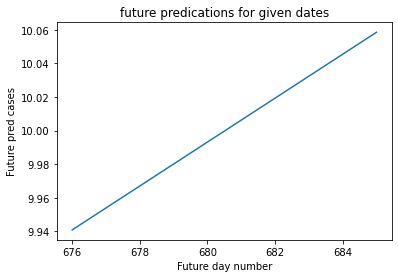

In [195]:
#plotting the trend line for future predicted cases
plt.plot(future_dates,future_predicted_cases)
plt.xlabel('Future day number')
plt.ylabel('Future pred cases')
plt.title("future predications for given dates")

## Linear regression for Deaths

In [196]:
#getting teh only deaths, deaths and day count in the table for model
Clay_day1_deaths_m =Clay_day1_deaths[['day_count','New deaths']]

In [197]:
Clay_day1_deaths_m.tail()

,day_count,New deaths
752,494,0.0
753,495,0.0
754,496,0.0
755,497,0.0
756,498,0.0


In [198]:
#getting the 10 percen value for testing data
round((Clay_day1_deaths_m.shape[0]/100)*10)

50

In [199]:
#splitting the data into tain test
x_train=Clay_day1_deaths_m['day_count'][:Clay_day1_deaths_m.shape[0]-30]
y_train=Clay_day1_deaths_m['New deaths'][:Clay_day1_deaths_m.shape[0]-30]

#test data
x_test=Clay_day1_deaths_m['day_count'][Clay_day1_deaths_m.shape[0]-30:]
y_test=Clay_day1_deaths_m['New deaths'][Clay_day1_deaths_m.shape[0]-30:]


In [200]:
#getting the data for x and y independently
x_train = np.array(x_train).reshape(-1,1)
x_test = np.array(x_test).reshape(-1,1)


In [201]:
#fitting the Linear regression model
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [202]:
#predicting the values for the test data
lr_pred_test = lr.predict(x_test)
lr_pred_test

array([-0.01039551, -0.011023  , -0.0116505 , -0.01227799, -0.01290549,
       -0.01353298, -0.01416048, -0.01478797, -0.01541547, -0.01604296,
       -0.01667046, -0.01729795, -0.01792545, -0.01855294, -0.01918044,
       -0.01980793, -0.02043543, -0.02106292, -0.02169042, -0.02231792,
       -0.02294541, -0.02357291, -0.0242004 , -0.0248279 , -0.02545539,
       -0.02608289, -0.02671038, -0.02733788, -0.02796537, -0.02859287])

In [203]:
rmse = sqrt(mean_squared_error(y_test, lr_pred_test))
rmse

0.263405736796193

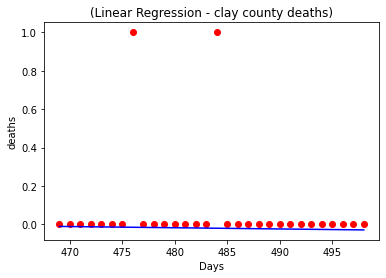

In [204]:
#plotting for linear regression for clay county  deaths
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test, lr_pred_test, color='blue')
plt.title('(Linear Regression - clay county deaths)')
plt.xlabel('Days')
plt.ylabel('deaths')
plt.show()

## Polynomial Regression for Deaths

RMSE for degree 1 is 0.263405736796193
RMSE for degree 2 is 0.32845276057573
RMSE for degree 3 is 0.26396129814170877
RMSE for degree 4 is 0.2556717141674857


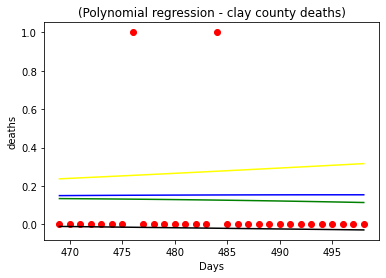

In [205]:
#performing polynomial regression for the clay county
degree=1
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict1 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict1))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=2
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict2 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict2))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=3
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict3 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict3))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=4
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict4 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict4))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))


#PLotting th graph for all 4 degrees for polynomial regression
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test,poly_test_predict1 , color='black')
plt.plot(x_test,poly_test_predict2 , color='yellow')
plt.plot(x_test,poly_test_predict3 , color='blue')
plt.plot(x_test,poly_test_predict4 , color='green')
plt.title('(Polynomial regression - clay county deaths)')
plt.xlabel('Days')
plt.ylabel('deaths')
plt.show()

### Confidence interval for clay county deaths

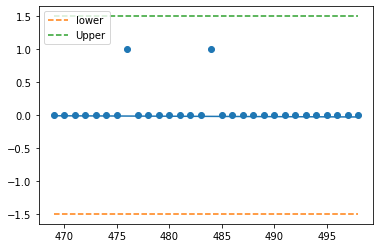

In [206]:
# ref: https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

upper, lower = [], []
for i in range(len(x_test)):
    lower.append(get_prediction_interval(i,y_test, lr_pred_test)[0])
    upper.append(get_prediction_interval(i,y_test, lr_pred_test)[2])
upper=[1.5]*len(upper)
lower=[-1.5]*len(lower)
plt.scatter(x_test,y_test)
plt.plot(x_test,lr_pred_test)
plt.plot(x_test,lower,'--',label='lower')
plt.plot(x_test,upper,'--',label='Upper')
plt.legend(loc='upper left')

### Clay County deaths Forecast

In [207]:
Clay_day1_deaths_m.tail()

,day_count,New deaths
752,494,0.0
753,495,0.0
754,496,0.0
755,497,0.0
756,498,0.0


In [208]:
future_dates= np.arange(499,509)

In [209]:
future_dates

array([499, 500, 501, 502, 503, 504, 505, 506, 507, 508])

In [210]:
#predicting the values for future dates
future_predicted_deaths=lr.predict(future_dates.reshape(-1,1))

Text(0.5, 1.0, 'future predications for given dates')

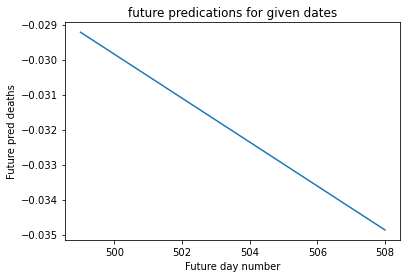

In [211]:
#plotting the trend line for future predicted cases
plt.plot(future_dates,future_predicted_deaths)
plt.xlabel('Future day number')
plt.ylabel('Future pred deaths')
plt.title("future predications for given dates")

# Johnson County

In [212]:
#getting the Johnson county data
Johnson=top5_counties[top5_counties['County Name']=='Johnson County ']

In [213]:
#getting the requries variables and resetting the index
Johnson=Johnson[['Date','New cases','New deaths']]
Johnson.reset_index(inplace=True,drop=True)
Johnson

,Date,New cases,New deaths
0,2020-01-23,0.0,0.0
1,2020-01-24,0.0,0.0
2,2020-01-25,0.0,0.0
3,2020-01-26,0.0,0.0
4,2020-01-27,0.0,0.0
...,...,...,...
752,2022-02-13,31.0,0.0
753,2022-02-14,2.0,0.0
754,2022-02-15,5.0,0.0
755,2022-02-16,17.0,1.0


In [214]:
#getting the index of the occurance of first case and first death in the county
Johnson_case_index= Johnson['New cases'].ne(0).idxmax() 
Johnson_death_index= Johnson['New deaths'].ne(0).idxmax()
print('first case index is',Johnson_case_index)
print('first death index is',Johnson_death_index)


first case index is 81
first death index is 295


In [215]:
#removinf the rows before the first day of case and deat occurance in data
Johnson_day1_cases=Johnson[['Date','New cases']][Johnson_case_index:]
Johnson_day1_deaths=Johnson[['Date','New deaths']][Johnson_death_index:]

In [216]:
print('shape',Johnson_day1_cases.shape)
Johnson_day1_cases.tail(3)


shape (676, 2)


,Date,New cases
754,2022-02-15,5.0
755,2022-02-16,17.0
756,2022-02-17,10.0


In [217]:
print('shape',Johnson_day1_deaths.shape)

Johnson_day1_deaths.tail(3)

shape (462, 2)


,Date,New deaths
754,2022-02-15,0.0
755,2022-02-16,1.0
756,2022-02-17,1.0


In [218]:
#getting the count of days from isrt day os case occurance
Johnson_day1_cases['day_count']=''
c=Johnson_case_index
for i in range(1,Johnson_day1_cases.shape[0]+1):
    Johnson_day1_cases['day_count'][c]=i
    c=c+1

#displaying the data with day count    
Johnson_day1_cases.tail()


,Date,New cases,day_count
752,2022-02-13,31.0,672
753,2022-02-14,2.0,673
754,2022-02-15,5.0,674
755,2022-02-16,17.0,675
756,2022-02-17,10.0,676


In [219]:
#getting the count of days from fisrt day of death occurance
Johnson_day1_deaths['day_count']=''
d=Johnson_death_index
for i in range(1,Johnson_day1_deaths.shape[0]+1):
    Johnson_day1_deaths['day_count'][d]=i
    d=d+1

#displayig the data with day count    
Johnson_day1_deaths.tail()

,Date,New deaths,day_count
752,2022-02-13,0.0,458
753,2022-02-14,0.0,459
754,2022-02-15,0.0,460
755,2022-02-16,1.0,461
756,2022-02-17,1.0,462


## Linear regression for Cases 

In [220]:
#getting teh only cases, deaths and day count in the table for model
Johnson_day1_cases_m =Johnson_day1_cases[['day_count','New cases']]

In [221]:
Johnson_day1_cases_m.tail()

,day_count,New cases
752,672,31.0
753,673,2.0
754,674,5.0
755,675,17.0
756,676,10.0


In [222]:
#getting the 10 percen value for testing data
round((Johnson_day1_cases_m.shape[0]/100)*10)

68

In [223]:
#splitting the data into tain test
x_train=Johnson_day1_cases_m['day_count'][:Johnson_day1_cases.shape[0]-68]
y_train=Johnson_day1_cases_m['New cases'][:Johnson_day1_cases.shape[0]-68]

#test data
x_test=Johnson_day1_cases_m['day_count'][Johnson_day1_cases.shape[0]-68:]
y_test=Johnson_day1_cases_m['New cases'][Johnson_day1_cases.shape[0]-68:]


In [224]:
y_test.shape

(68,)

In [225]:
#getting the data for x and y independently
x_train = np.array(x_train).reshape(-1,1)
x_test = np.array(x_test).reshape(-1,1)


In [226]:
#fitting the Linear regression model
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [227]:
#predicting the values for the test data
lr_pred_test = lr.predict(x_test)
lr_pred_test

array([6.41164485, 6.41886267, 6.4260805 , 6.43329833, 6.44051616,
       6.44773399, 6.45495182, 6.46216965, 6.46938748, 6.47660531,
       6.48382314, 6.49104097, 6.4982588 , 6.50547663, 6.51269446,
       6.51991229, 6.52713012, 6.53434795, 6.54156577, 6.5487836 ,
       6.55600143, 6.56321926, 6.57043709, 6.57765492, 6.58487275,
       6.59209058, 6.59930841, 6.60652624, 6.61374407, 6.6209619 ,
       6.62817973, 6.63539756, 6.64261539, 6.64983322, 6.65705105,
       6.66426887, 6.6714867 , 6.67870453, 6.68592236, 6.69314019,
       6.70035802, 6.70757585, 6.71479368, 6.72201151, 6.72922934,
       6.73644717, 6.743665  , 6.75088283, 6.75810066, 6.76531849,
       6.77253632, 6.77975415, 6.78697197, 6.7941898 , 6.80140763,
       6.80862546, 6.81584329, 6.82306112, 6.83027895, 6.83749678,
       6.84471461, 6.85193244, 6.85915027, 6.8663681 , 6.87358593,
       6.88080376, 6.88802159, 6.89523942])

In [228]:
rmse = sqrt(mean_squared_error(y_test, lr_pred_test))
rmse

31.597524180008534

### Trend Line

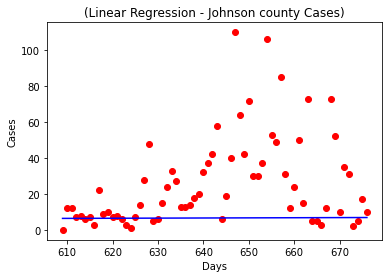

In [229]:
#plotting for linear regression for johnson county  cases
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test, lr_pred_test, color='blue')
plt.title('(Linear Regression - Johnson county Cases)')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.show()

## Polynomial Regression for Cases

### Trend Line

RMSE for degree 1 is 31.597524180008534
RMSE for degree 2 is 32.94572448350795
RMSE for degree 3 is 28.676411759470238
RMSE for degree 4 is 29.25282076088395


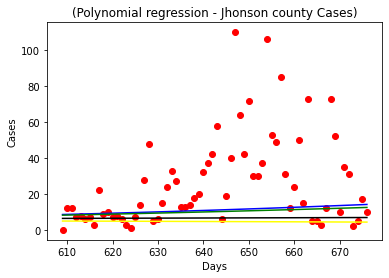

In [230]:
#performing polynomial regression for the Jhonson county
degree=1
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict1 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict1))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=2
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict2 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict2))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=3
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict3 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict3))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=4
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict4 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict4))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))


#PLotting th graph for all 4 degrees for polynomial regression
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test,poly_test_predict1 , color='black')
plt.plot(x_test,poly_test_predict2 , color='yellow')
plt.plot(x_test,poly_test_predict3 , color='blue')
plt.plot(x_test,poly_test_predict4 , color='green')
plt.title('(Polynomial regression - Jhonson county Cases)')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.show()

### Confidence interval for Jhonson county cases 

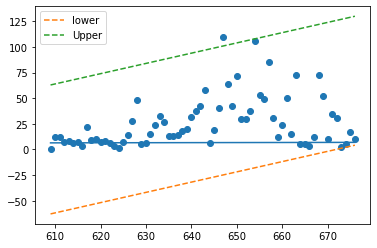

In [231]:
# ref: https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

upper, lower = [], []
for i in range(len(x_test)):
    lower.append(get_prediction_interval(i,y_test, lr_pred_test)[0])
    upper.append(get_prediction_interval(i,y_test, lr_pred_test)[2])

plt.scatter(x_test,y_test)
plt.plot(x_test,lr_pred_test)
plt.plot(x_test,lower,'--',label='lower')
plt.plot(x_test,upper,'--',label='Upper')
plt.legend(loc='upper left')

### Johnson County cases Forecast

In [232]:
Johnson_day1_cases_m.tail()

,day_count,New cases
752,672,31.0
753,673,2.0
754,674,5.0
755,675,17.0
756,676,10.0


In [233]:
future_dates= np.arange(677,687)

In [234]:
future_dates

array([677, 678, 679, 680, 681, 682, 683, 684, 685, 686])

In [235]:
#predicting the values for future dates
future_predicted_cases=lr.predict(future_dates.reshape(-1,1))

Text(0.5, 1.0, 'future predications for given dates')

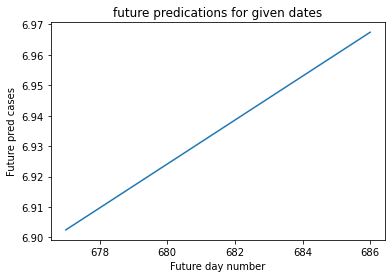

In [236]:
#plotting the trend line for future predicted cases
plt.plot(future_dates,future_predicted_cases)
plt.xlabel('Future day number')
plt.ylabel('Future pred cases')
plt.title("future predications for given dates")

## Linear regression for Deaths

In [237]:
#getting teh only deaths, deaths and day count in the table for model
Johnson_day1_deaths_m =Johnson_day1_deaths[['day_count','New deaths']]

In [238]:
Johnson_day1_deaths_m.tail()

,day_count,New deaths
752,458,0.0
753,459,0.0
754,460,0.0
755,461,1.0
756,462,1.0


In [239]:

#getting the 10 percen value for testing data
round((Johnson_day1_deaths_m.shape[0]/100)*10)

46

In [240]:
#splitting the data into tain test
x_train=Johnson_day1_deaths_m['day_count'][:Johnson_day1_deaths_m.shape[0]-46]
y_train=Johnson_day1_deaths_m['New deaths'][:Johnson_day1_deaths_m.shape[0]-46]

#test data
x_test=Johnson_day1_deaths_m['day_count'][Johnson_day1_deaths_m.shape[0]-46:]
y_test=Johnson_day1_deaths_m['New deaths'][Johnson_day1_deaths_m.shape[0]-46:]


In [241]:
#getting the data for x and y independently
x_train = np.array(x_train).reshape(-1,1)
x_test = np.array(x_test).reshape(-1,1)


In [242]:
#fitting the Linear regression model
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [243]:
#predicting the values for the test data
lr_pred_test = lr.predict(x_test)
lr_pred_test

array([0.08694393, 0.08683058, 0.08671723, 0.08660389, 0.08649054,
       0.08637719, 0.08626384, 0.0861505 , 0.08603715, 0.0859238 ,
       0.08581045, 0.0856971 , 0.08558376, 0.08547041, 0.08535706,
       0.08524371, 0.08513037, 0.08501702, 0.08490367, 0.08479032,
       0.08467698, 0.08456363, 0.08445028, 0.08433693, 0.08422358,
       0.08411024, 0.08399689, 0.08388354, 0.08377019, 0.08365685,
       0.0835435 , 0.08343015, 0.0833168 , 0.08320346, 0.08309011,
       0.08297676, 0.08286341, 0.08275007, 0.08263672, 0.08252337,
       0.08241002, 0.08229667, 0.08218333, 0.08206998, 0.08195663,
       0.08184328])

In [244]:
rmse = sqrt(mean_squared_error(y_test, lr_pred_test))
rmse

0.39878781524423446

### Trend Line

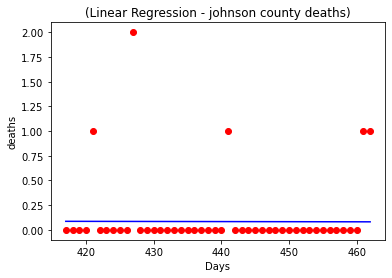

In [245]:
#plotting for linear regression for johnson county  deaths
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test, lr_pred_test, color='blue')
plt.title('(Linear Regression - johnson county deaths)')
plt.xlabel('Days')
plt.ylabel('deaths')
plt.show()

## Polynomial Regression for Deaths

### Trend Line

RMSE for degree 1 is 0.39878781524423446
RMSE for degree 2 is 0.40656503335918037
RMSE for degree 3 is 0.4978023285428773
RMSE for degree 4 is 0.5205550467472317


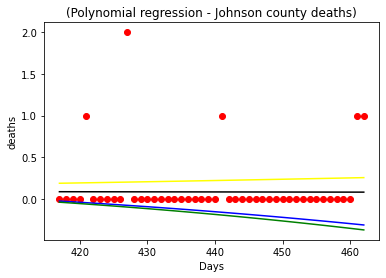

In [246]:
#performing polynomial regression for the Johnson county
degree=1
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict1 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict1))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=2
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict2 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict2))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=3
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict3 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict3))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))

degree=4
polynomial_rg = PolynomialRegression(degree)
polynomial_rg.fit(x_train, y_train)
poly_test_predict4 =polynomial_rg.predict(x_test)
polynomial_rmse = sqrt(mean_squared_error(y_test, poly_test_predict4))
print('RMSE for degree {} is {}'.format(degree,polynomial_rmse))


#PLotting th graph for all 4 degrees for polynomial regression
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test,poly_test_predict1 , color='black')
plt.plot(x_test,poly_test_predict2 , color='yellow')
plt.plot(x_test,poly_test_predict3 , color='blue')
plt.plot(x_test,poly_test_predict4 , color='green')
plt.title('(Polynomial regression - Johnson county deaths)')
plt.xlabel('Days')
plt.ylabel('deaths')
plt.show()

### Confidence interval for Jhonson county deaths

As the linear regression model is havinf the least rmse it is the best for the data

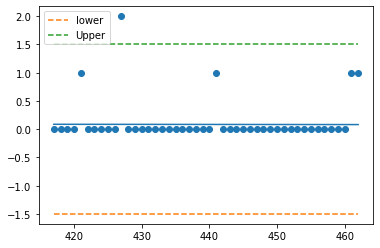

In [247]:
# ref: https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

upper, lower = [], []
for i in range(len(x_test)):
    lower.append(get_prediction_interval(i,y_test, lr_pred_test)[0])
    upper.append(get_prediction_interval(i,y_test, lr_pred_test)[2])
upper=[1.5]*len(upper)
lower=[-1.5]*len(lower)
plt.scatter(x_test,y_test)
plt.plot(x_test,lr_pred_test)
plt.plot(x_test,lower,'--',label='lower')
plt.plot(x_test,upper,'--',label='Upper')
plt.legend(loc='upper left')

### Johnson County deaths Forecast

In [248]:
Johnson_day1_deaths_m.tail()

,day_count,New deaths
752,458,0.0
753,459,0.0
754,460,0.0
755,461,1.0
756,462,1.0


In [249]:
future_dates= np.arange(463,473)

In [250]:
future_dates

array([463, 464, 465, 466, 467, 468, 469, 470, 471, 472])

In [251]:
#predicting the values for future dates
future_predicted_deaths=lr.predict(future_dates.reshape(-1,1))

Text(0.5, 1.0, 'future predications for given dates')

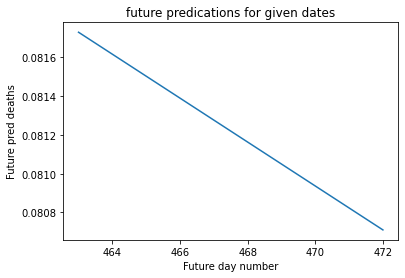

In [252]:
#plotting the trend line for future predicted cases
plt.plot(future_dates,future_predicted_deaths)
plt.xlabel('Future day number')
plt.ylabel('Future pred deaths')
plt.title("future predications for given dates")

## Enrichment Data 

In [253]:
import pingouin as pg



In [254]:
social_char=pd.read_csv("../../../data/member/Nikhil/social_char.csv")

In [255]:
social_char = social_char.groupby(by=['State']).mean()

#### Can we say that households with age greater than 65 are highly effected to covid 19


In [ ]:
stats.ttest_ind(a=social_char['Cases'], b= social_char['Households with Senior'],equal_var=False)

As the p-value is less than 0.05, we reject the null hypothesis states that households with seniors are not much affected by covid

#### can we say there is a decrease in High school enrollments due to the increase in the Covid cases

In [ ]:
stats.ttest_ind(a=social_char['Cases'], b= social_char['Number of Enrollments in High School'],equal_var=False)

As the p-value is less than 0.05, we reject the null hypothesis states that Number of Enrollments in High School are not much affected by covid